# Simulation of a Federated KMeans using scikit Learn and Federated Averaging

The purpose of this notebook is to test a KMeans algorithm in a federated setting.

Clustering data will be generated iusing `make_blob` function

In [1]:
from typing import List, Dict, Tuple

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin, pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.datasets import make_blobs

## Dataset generation

 1. Problem 1
 


In [2]:
# dataset parameters
SEED = 1234
np.random.seed(SEED)


## parameters for data generation
cluster_centers = [[1, 1], [-1, -1], [1, -1], [0, 1]]
n_samples = 200
cluster_std = .9
space_dim = 2

## algorithm parameters
batch_size = 20
n_init = 10  # nb of random initialization
n_clusters = 4
n_epochs = 10
## nodes parameters (for federated learning only)

nodes_id = ["alice", "bob", "charlie", "danny"]
n_rounds = 200
distance_metric = "euclidean"
nb_samples_per_nodes = [1, 1, 1, 1] # indicates how to sample data per node

In [3]:
# random seed
np.random.seed(SEED)

In [4]:
# generate dataset


X, labels_true = make_blobs(n_samples=n_samples, centers=cluster_centers, cluster_std=cluster_std)

## training on local dataset

Th goal of this sub section is to compare performance of K means on local dataset and on the same dataset but split among clients. 

Here we will train a k mean on local dataset, using `partial_fit` (performing one update using one batch size).

We iterate over partial fit to perfrom a complete epoch.

In [5]:
# train kmeans on local dataset
mbk_local = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                              n_init=10, max_no_improvement=10, verbose=0, random_state=SEED)


history_local = {"euclidian": [], "obj": [], "db": []}
for r in range(n_rounds):
    for epoch in range(n_epochs):
        mbk_local.partial_fit(X) 

        
        history_local["obj"].append(mbk_local.score(X))
        order = pairwise_distances_argmin(cluster_centers,
                                  mbk_local.cluster_centers_,
                                     metric=distance_metric)
        euclidian_dist = np.sum(np.square(mbk_local.cluster_centers_[order] - cluster_centers), axis=1)

    history_local["euclidian"].append(np.sqrt(euclidian_dist).tolist())
    predicted = mbk_local.predict(X)
    db_score = davies_bouldin_score(X, predicted)
    history_local["db"].append(db_score)

### displaying local mini batch results & losses plots

Text(0.5, 0, ' rounds')

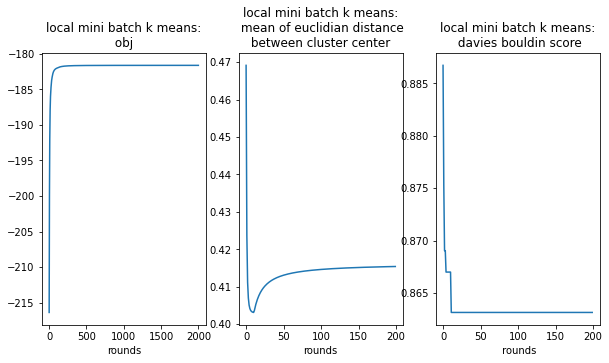

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,3, 1)
plt.title("local mini batch k means:\n obj ")
plt.plot(history_local["obj"])
plt.xlabel("rounds")

plt.subplot(1,3,2)
plt.title("local mini batch k means:\n mean of euclidian distance\n between cluster center ")
plt.plot(np.mean(history_local["euclidian"], axis=1))
plt.xlabel("rounds")


plt.subplot(1,3,3)

plt.title("local mini batch k means:\n davies bouldin score")
plt.plot(history_local["db"])
plt.xlabel(" rounds")

### Displaying clustering results

Mini batch k mean inertia:  181.62047088449808


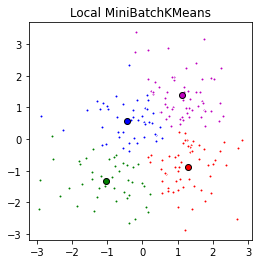

In [7]:
# plot results

mbk_local_cluster_centers = mbk_local.cluster_centers_
mbk_local_labels = mbk_local.predict(X)
colors = ['r', 'b', 'g', 'm']

fig = plt.figure(figsize=(4, 4))


for k, col in zip(range(n_clusters), colors):
    my_members = mbk_local_labels == k
    cluster_center = mbk_local_cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
plt.title('Local MiniBatchKMeans')
print("Mini batch k mean inertia: ", mbk_local.inertia_)

## KMeans in a federated environment

### 1. split data into different nodes

In [8]:
def generate_federated_clustering_dataset(dataset: np.ndarray,
                                          labels: np.ndarray,
                                          nodes_id: List[str],
                                          nb_samples_per_nodes: list,
                                         random_seed:int=None) -> Tuple[Dict[str, np.ndarray],
                                                                        Dict[str, np.ndarray]]:
    """
    Split classification / clustering dataset into several nodes
    
    Args:
    
    Returns:
    federated_dataset (Dict[str, np.ndarray]): a dictionary containing node id defined in argument
    `nodes_id` mapping their respective training input datasets
    federated_labels (Dict[str, np.ndarray]]): a dictionary containing node id defined in argument
    `nodes_id` mapping their respective training label datasets (from which cluster point in 
    `federated_dataset` returned argument belongs to)
    """
    
    assert len(nodes_id) == len(nb_samples_per_nodes), "len(nodes_id) must equal len(nb_samples_per_nodes)"
    nb_samples_per_nodes = np.array(nb_samples_per_nodes)
    w_sum_nodes = nb_samples_per_nodes / nb_samples_per_nodes.sum()
    
    nb_samples = labels.shape[0]
    w_sum_nodes *= nb_samples
    
    print(w_sum_nodes)
    
        
    all_X, all_labels = {}, {}
    labels_tags = np.unique(labels)
    n_labels = len(labels_tags)
        
    idx_pointer = np.zeros((n_labels))
    
    # this part is for splitting equally cluster for nodes
    # making sure every clients have the same number of labels
    for i,idx in enumerate(w_sum_nodes):
        # iterates over node"
        for i_lab, lab in enumerate(labels_tags):
            label_idx = lab == labels

            idx1 = int(idx_pointer[i_lab])
            idx2 = idx1 + int(np.floor(idx / n_labels))

            #idx1_sample, idx2_sample = int(np.floor(idx / n_labels)), int(np.floor(idx / n_labels))
            sampled_X, sampled_labels = (dataset[label_idx][idx1: idx2],
                                            labels[label_idx][idx1: idx2])
            if nodes_id[i] not in all_X.keys():
                all_X[nodes_id[i]] = sampled_X
                all_labels[nodes_id[i]] = sampled_labels
            else:
                all_X[nodes_id[i]] = np.concatenate([all_X[nodes_id[i]], sampled_X], axis=0)
                all_labels[nodes_id[i]] = np.concatenate([all_labels[nodes_id[i]], sampled_labels], axis=0)
            idx1 = idx2
            idx_pointer[i_lab] = idx1
        
    
    
    # this part is for splitting remaining points into 
    # nodes datasets: as a consequence, datasets among clients will be uneven
    remaining_data_pts = dataset.shape[0] - idx_pointer.sum()
    print("remaining : ", remaining_data_pts, " points")
    for i,idx in enumerate(w_sum_nodes):

        if all_labels[nodes_id[i]].shape[0] < idx:
            diff = np.abs(all_labels[nodes_id[i]].shape[0] - idx)
            diff = np.ceil(diff)
            #diff = nb_samples - idx_pointer.sum()
            
            while diff> 0 and remaining_data_pts >0:
                for i_lab, lab in enumerate(labels_tags):

                    label_idx = lab == labels
                    idx1 = int(idx_pointer[i_lab])
                    #maximum = int(np.ceil(labels[label_idx].shape[0] / len(nodes_id)))
                    maximum = int(labels[label_idx].shape[0])

                    if idx1  < maximum :


                        all_X[nodes_id[i]] = np.concatenate([all_X[nodes_id[i]],
                                                             dataset[label_idx][idx1].reshape(1,-1)],
                                                            axis=0)

                        all_labels[nodes_id[i]] = np.concatenate([all_labels[nodes_id[i]],
                                                                  np.array([labels[label_idx][idx1]])], axis=0)
                        diff -= 1
                        idx1 += 1
                        remaining_data_pts -= 1
                        idx_pointer[i_lab] = idx1
                        if diff == 0:
                            break
                    else:
                        continue
                print("added remaining point(s) to node ", nodes_id[i])
                
        print(idx_pointer)
        
        # randomly permute index of dataset of each node
        if random_seed is not None:
            rng = np.random.RandomState(random_seed)
            permuted_idx = rng.permutation(all_labels[nodes_id[i]].shape[0])
            all_X[nodes_id[i]]  = all_X[nodes_id[i]] [permuted_idx]
            all_labels[nodes_id[i]] = all_labels[nodes_id[i]][permuted_idx]
    return all_X, all_labels

In [9]:
federated_dataset, federated_labels = generate_federated_clustering_dataset(X,
                                                                            labels_true,
                                                                            nodes_id,
                                                                            nb_samples_per_nodes,
                                                                            random_seed=SEED
                                                                           )

[50. 50. 50. 50.]
remaining :  8.0  points
added remaining point(s) to node  alice
[49. 49. 48. 48.]
added remaining point(s) to node  bob
[50. 50. 48. 48.]
added remaining point(s) to node  charlie
[50. 50. 49. 49.]
added remaining point(s) to node  danny
[50. 50. 50. 50.]


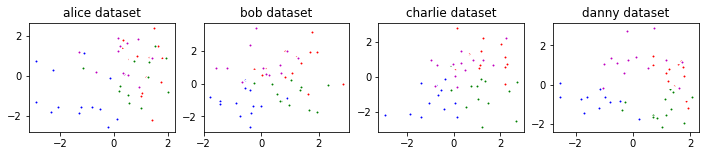

In [10]:
plt.figure(figsize=(12, 2))
n_clients = len(nodes_id)
for n_cli, cli in enumerate(nodes_id):
    plt.subplot(1, n_clients, n_cli+1)
    for k, col in zip(range(n_clusters), colors):
        my_members = federated_labels[cli] == k
        
        plt.plot(federated_dataset[cli][my_members, 0], federated_dataset[cli][my_members, 1], 'w',
                markerfacecolor=col, marker='.')
        plt.title(f"{cli} dataset")
        

### 2. Create different nodes

In [11]:
# create several nodes (as many as in nodes_id)

nodes = {}

for n in nodes_id:
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=batch_size,
                              n_init=10, max_no_improvement=10, verbose=0, random_state=SEED)
    nodes[n] = {'model' : mbk}

training:


In [12]:
history = {"obj": [], 'db':[], 'euclidian': []}

# initialisation: compute dataset weigths
w_sum = 0
for n in nodes.keys():
    nodes[n]['weigths'] = federated_dataset[n].shape[0]
w_sum +=  nodes[n]['weigths']
for n in nodes.keys():
    nodes[n]['weigths'] /= w_sum

In [ ]:
nodes

there is still an issue in the code : in this piece of code cluster distance are assumed to be unique
If not, training is unstable; and cluster centers will not be averaged correctly

In [ ]:


# federated training
for r in range(n_rounds):
    for n in nodes_id:
        for epoch in range(n_epochs):
            nodes[n]['model'].partial_fit(federated_dataset[n]) 
    
    # fedavg aggregating
        
    
            print(n, nodes[n]['model'].cluster_centers_)
    cluster_w = np.zeros((n_clusters, space_dim)).copy()
    #cluster_w = np.zeros((n_clusters, dim))
    order_memory = {}
    for i, n in enumerate(nodes_id):
        ref_order_model = nodes[nodes_id
                                [0]]['model']
        if len(nodes_id) > 1:
            comp_model = nodes[n]['model']
            order = pairwise_distances_argmin(ref_order_model.cluster_centers_,
                                              comp_model.cluster_centers_,
                                                 metric=distance_metric)
            
        else:
            order = np.arange(n_clusters)  # special case where only one node is considered
        order_memory[n] = order
        print(order)
        for c in range(n_clusters):
        
            if i == 0:
                
                cluster_w[c] += ref_order_model.cluster_centers_[c]* nodes[n]['weigths']
            else:
                cluster_w[c] += nodes[n]['model'].cluster_centers_[order][c] * nodes[n]['weigths']
            
    for c in range(n_clusters):        
        cluster_w[c] = cluster_w[c]/len(nodes_id)

    # update 
    for n in nodes_id:
        nodes[n]['model'].cluster_centers_ = cluster_w.copy()[order]
        print(n, nodes[n]['model'].cluster_centers_, '\n', cluster_w)
        # update history (predict on global dataset)
    predicted = nodes[n]['model'].predict(X)
    history["obj"].append(nodes[n]['model'].score(X))
    
    if len(np.unique(predicted)) == 1:
        db_score = 0
    else:
        db_score = davies_bouldin_score(X,predicted)
    history["db"].append(db_score)
    order = pairwise_distances_argmin(cluster_centers,
                                  nodes[n]['model'].cluster_centers_,
                                     metric=distance_metric)
    euclidian_dist = np.sum(np.square(nodes[n]['model'].cluster_centers_[order] - cluster_centers), axis=1)
    history["euclidian"].append(np.sqrt(euclidian_dist).tolist())
          

### 3. result display

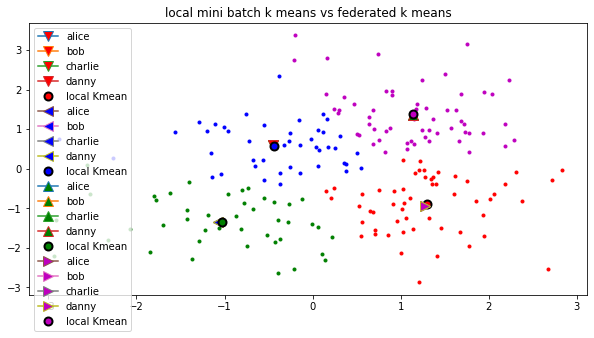

In [14]:
plt.figure(figsize=(10,5))
markers = ["v", "<", "^", ">"]
for cluster, col, m in zip(range(n_clusters), colors, markers):
    my_members = mbk_local_labels == cluster
    cluster_center = mbk_local.cluster_centers_[cluster]
    plt.scatter(X[my_members, 0], X[my_members, 1], 
             marker='.', c=col)
    
    
    
    for i, n in enumerate(nodes.keys()):
        plt.plot(nodes[n]['model'].cluster_centers_[cluster,0],
                nodes[n]['model'].cluster_centers_[cluster,1],
                 marker=m,  label=str(n), ms=10, mew=1, markerfacecolor=col)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=8, mew=2,label="local Kmean")
    
    plt.title("local mini batch k means vs federated k means")
plt.legend()

I decided to plot all nodes after final round, to make sure each client has the same clusters

In [15]:
order = pairwise_distances_argmin(mbk_local.cluster_centers_,
                                  nodes[n]['model'].cluster_centers_,
                                     metric=distance_metric)

mbk_local.cluster_centers_, nodes[n]['model'].cluster_centers_[order]

(array([[ 1.29478335, -0.89861653],
        [-0.43522969,  0.57844078],
        [-1.02891841, -1.33834747],
        [ 1.13579154,  1.38098617]]),
 array([[ 1.27332086, -0.9337444 ],
        [-0.44798613,  0.59228137],
        [-1.07018039, -1.35642881],
        [ 1.13630454,  1.35557895]]))

### Display plots of losses

Text(0.5, 0, 'rounds')

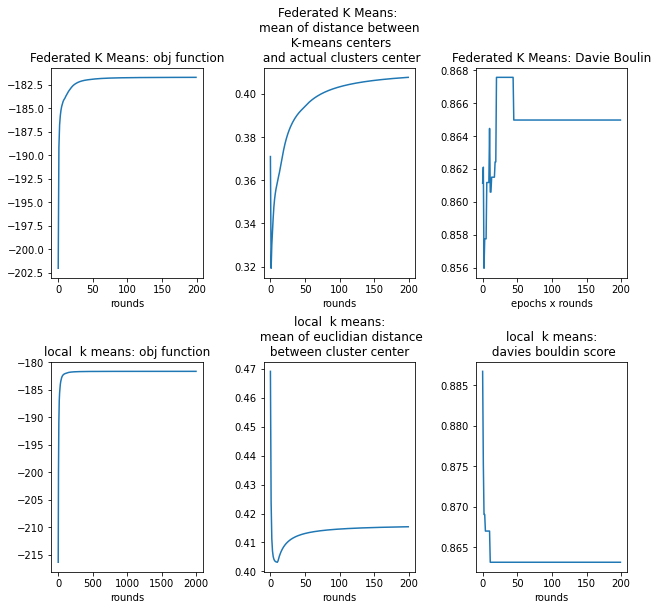

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
plt.plot(history["obj"])
plt.xlabel("rounds")
plt.title("Federated K Means: obj function")

plt.subplot(2,3,2)
plt.plot(np.mean(np.array(history["euclidian"]), axis=1))
plt.title("Federated K Means: \nmean of distance between\n K-means centers\n and actual clusters center")
plt.xlabel("rounds")

plt.subplot(2,3,3)
plt.plot(history["db"])
plt.title("Federated K Means: Davie Boulin")
plt.xlabel("epochs x rounds")

plt.subplot(2,3, 4)
plt.title("local  k means: obj function")
plt.plot(history_local["obj"])
plt.xlabel("rounds")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)
plt.subplot(2,3,5)
plt.title("local  k means:\n mean of euclidian distance\n between cluster center ")
plt.plot(np.mean(history_local["euclidian"], axis=1))
plt.xlabel("rounds")


plt.subplot(2,3,6)

plt.title("local  k means:\n davies bouldin score")
plt.plot(history_local["db"])
plt.xlabel("rounds")

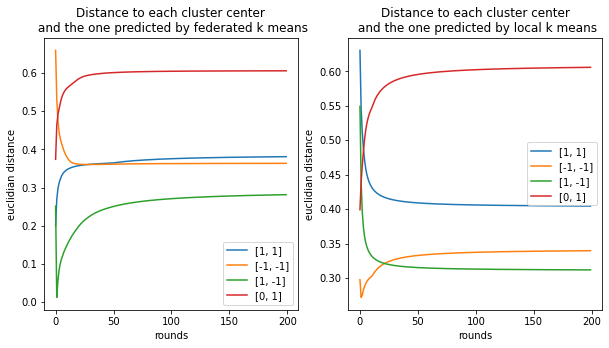

In [17]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

plt.plot(np.array(history["euclidian"]), label=cluster_centers)
plt.title("Distance to each cluster center\n and the one predicted by federated k means")
plt.xlabel("rounds")
plt.ylabel("euclidian distance")
plt.legend()


plt.subplot(1,2,2)
plt.plot(history_local["euclidian"], label=cluster_centers)
plt.title("Distance to each cluster center\n and the one predicted by local k means")
plt.xlabel("rounds")
plt.ylabel("euclidian distance")
plt.legend()